This notebook is the third part of an introduction to machine learning and implements, and improve, the the model from Part II to recognize handwritten digit from the MNIST, using PyTorch.

We saw in Part 1 and Part 2 how to create an MLP from scratch, allowing us to fully understand how they work. So in this part, we are going to see how to do it much faster using PyTorch. 

In this way we can fully concentrate on pre-processing our data and improving our previous methods to solve potential problems.

## Pre-Processing
Once again, we'll first do it manually to understand what we're doing, and then we'll see how to go much faster using PyTorch.

So firstly, we download our dataset (MNIST), for exemple on [Kaggle](https://www.kaggle.com/datasets/hojjatk/mnist-dataset). Note that we need to have separated train and test sets, or you can do it later directly in your code.

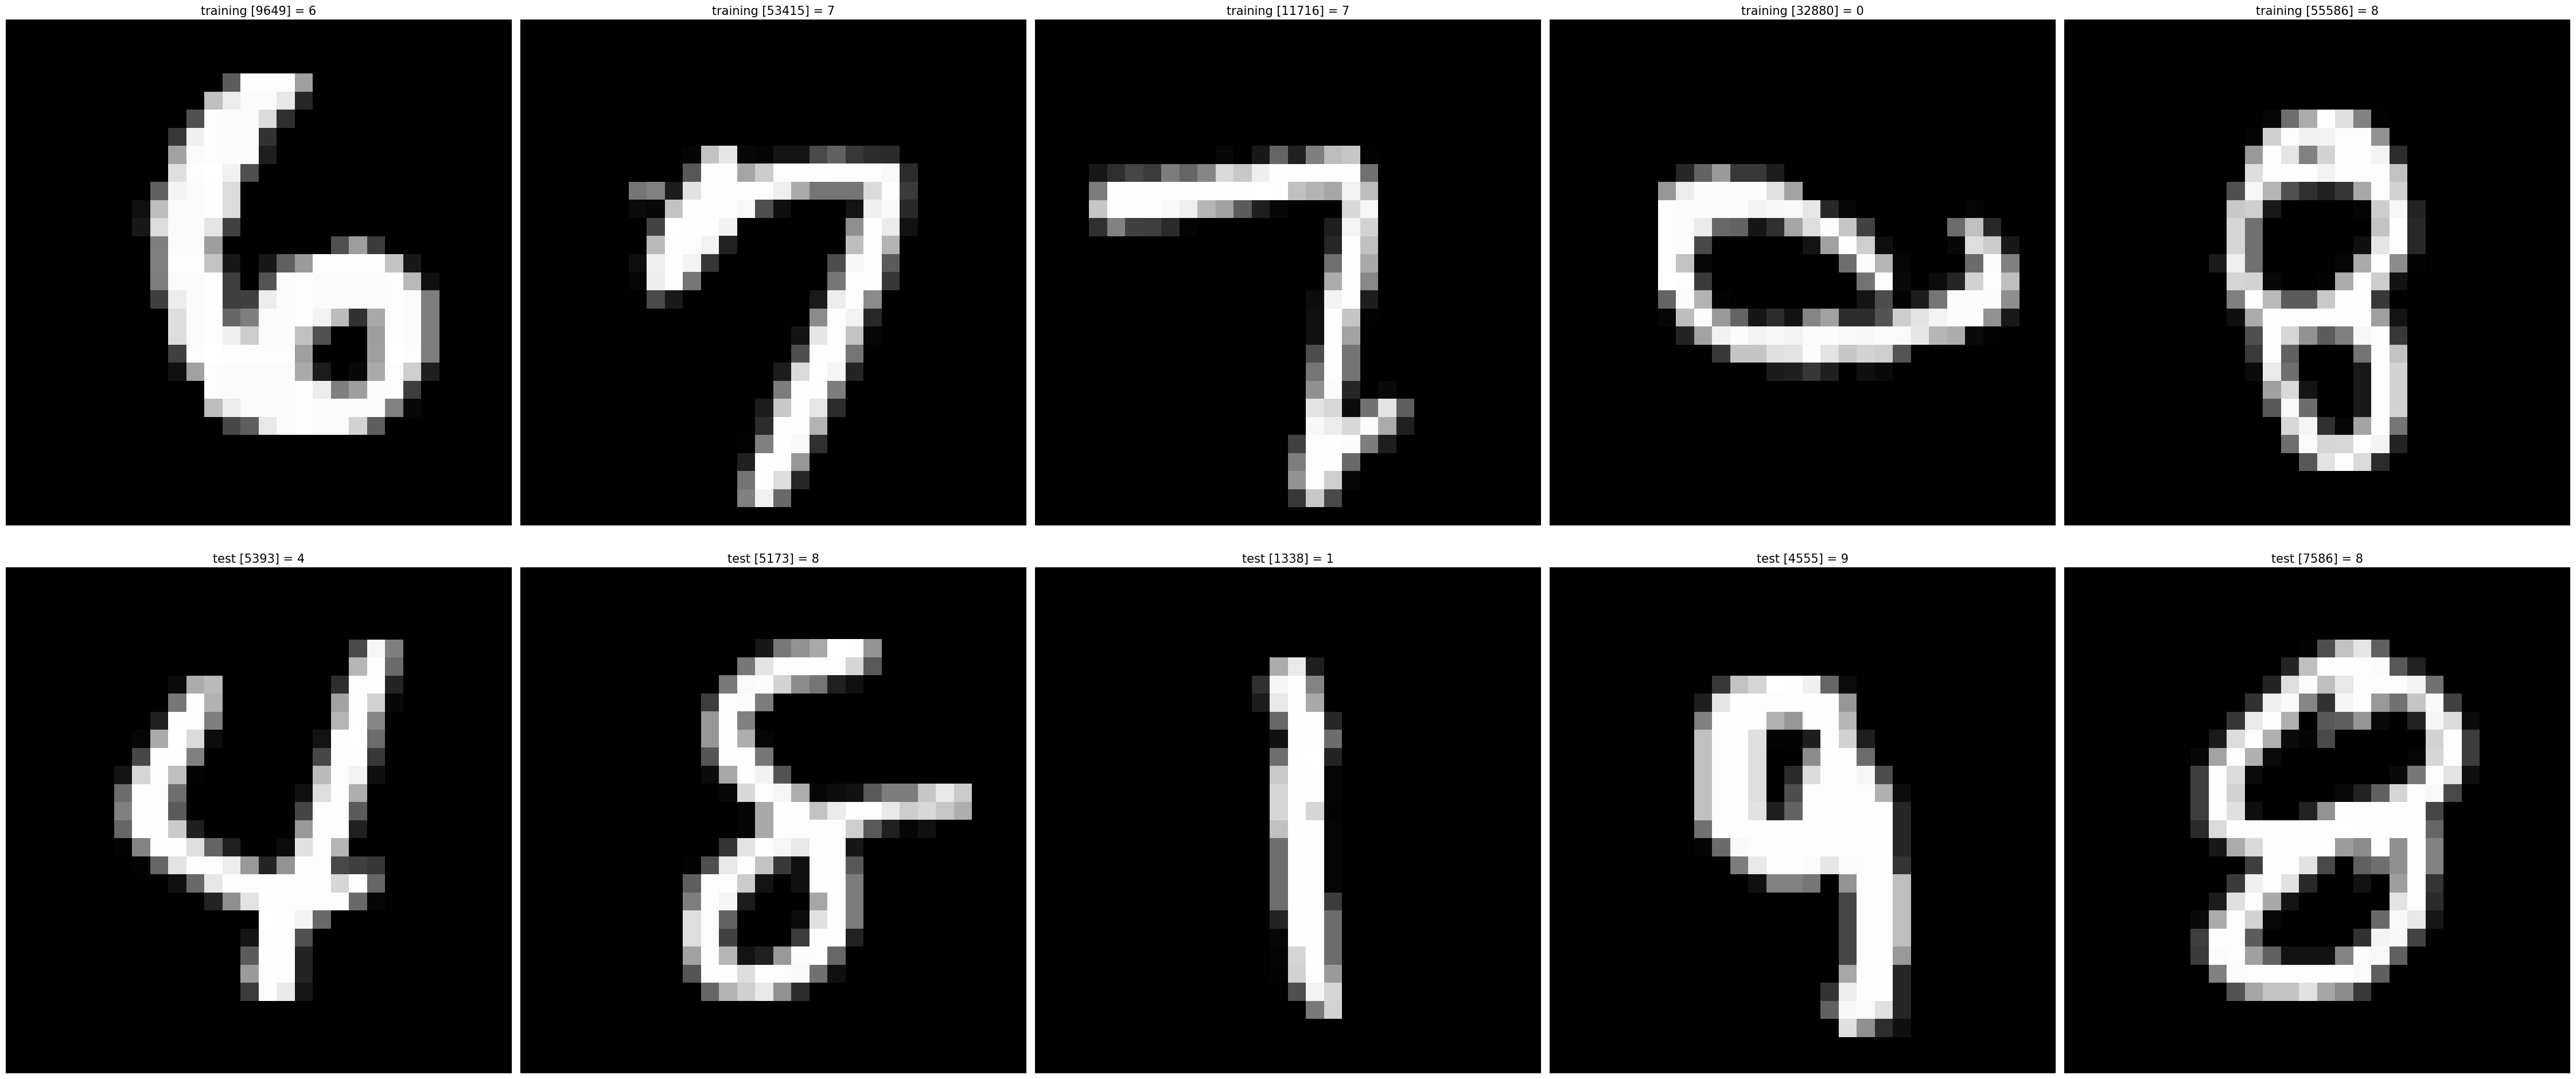

Saved: assets/mnist_preview.png


In [2]:
#(from kaggle)
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return np.array(images), np.array(labels)
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)  
    
#
# Verify Reading Dataset via MnistDataloader class
#

import os
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = './data/'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte')


def save_images_grid(images, title_texts, out_path="assets/samples.png", cols=5, figsize=(45, 20), dpi=100):
    # Crée le dossier si besoin
    os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)

    rows = (len(images) + cols - 1) // cols  # division plafond
    plt.figure(figsize=figsize)

    for idx, (image, title_text) in enumerate(zip(images, title_texts), start=1):
        plt.subplot(rows, cols, idx)
        plt.imshow(image, cmap=plt.cm.gray)
        if title_text:
            plt.title(title_text, fontsize=15)
        plt.axis("off")

    plt.tight_layout()
    plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.show()
    plt.close() 
    return out_path


# Load MNIST dataset
mnist_dataloader = MnistDataloader(
    training_images_filepath, training_labels_filepath,
    test_images_filepath, test_labels_filepath
)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Collect random training and test images
images_2_show = []
titles_2_show = []

for _ in range(5):
    r = random.randint(0, len(x_train) - 1)
    images_2_show.append(x_train[r])
    titles_2_show.append(f"training [{r}] = {y_train[r]}")

for _ in range(5):
    r = random.randint(0, len(x_test) - 1)
    images_2_show.append(x_test[r])
    titles_2_show.append(f"test [{r}] = {y_test[r]}")

# Save instead of show
path = save_images_grid(images_2_show, titles_2_show, out_path="assets/mnist_preview.png")
# path = save_images_grid(images_2_show, titles_2_show, out_path="../assets/mnist_preview.png")
print("Saved:", path)


We now have 2 step in order to prepare our data for our MLP:
- Vectorizarion
- Normalisation

### Vectorization
Our MLP need a set of shape nx2 (like our X from part 1 and 2) however here is what we got with our images :

In [3]:
print(np.shape(x_train))

(60000, 28, 28)


So we need to reshape the images into a column :

In [4]:
x_train_reshape = x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])
print(np.shape(x_train_reshape))

(60000, 784)


### Normalisation
All features must have the same order of importance or our z from parts 1 and 2 will be unbalanced by the heavy features which will count for much more.

In [5]:
img = x_train[0]
print(img[img>0])

[  3  18  18  18 126 136 175  26 166 255 247 127  30  36  94 154 170 253
 253 253 253 253 225 172 253 242 195  64  49 238 253 253 253 253 253 253
 253 253 251  93  82  82  56  39  18 219 253 253 253 253 253 198 182 247
 241  80 156 107 253 253 205  11  43 154  14   1 154 253  90 139 253 190
   2  11 190 253  70  35 241 225 160 108   1  81 240 253 253 119  25  45
 186 253 253 150  27  16  93 252 253 187 249 253 249  64  46 130 183 253
 253 207   2  39 148 229 253 253 253 250 182  24 114 221 253 253 253 253
 201  78  23  66 213 253 253 253 253 198  81   2  18 171 219 253 253 253
 253 195  80   9  55 172 226 253 253 253 253 244 133  11 136 253 253 253
 212 135 132  16]


We therefore need to normalize these values:

In [6]:
x_train_norm = x_train / x_train.max()
img = x_train_norm[0]
print(img[img>0][1])

0.07058823529411765


Let's do all of that (get the dataset, load the data and pre-process it) with PyTorch !

The following is mostly based on the excellent PyTorch documentation.

In [7]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

We can now download the MNIST dataset and directly convert the images to tensors while normalizing their pixel values using ToTensor(). Later, we will flatten them with nn.Flatten().

In [8]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="ptdata",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="ptdata",
    train=False,
    download=True,
    transform=ToTensor(),
)

Plotting images from the dataset is also way easier now :

torch.Size([1, 28, 28])


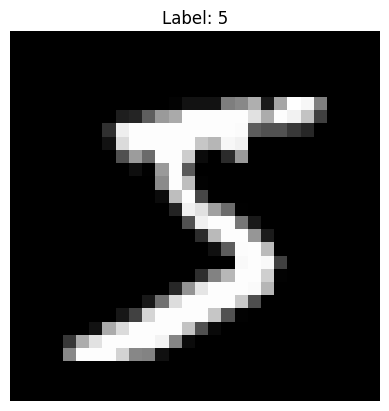

In [9]:
image, label = training_data[0] 
print(image.shape)

plt.imshow(image.squeeze(), cmap="gray")
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

In [10]:
batch_size = 30
# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [ ]:
#train/validation/test split
from torch.utils.data import random_split

batch_size = 30
train_size = 50_000
val_size = len(training_data) - train_size

train_subset, val_subset = random_split(
    training_data,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(0)  # reproductible
)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [13]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

hidden_size = 45

# Define model
class NeuralNetwork1(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

class NeuralNetwork2(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model1 = NeuralNetwork1().to(device)
model2 = NeuralNetwork2().to(device)

print(model1)
print(model2)

Using cpu device
NeuralNetwork1(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=45, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=45, out_features=10, bias=True)
  )
)
NeuralNetwork2(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=45, bias=True)
    (1): ReLU()
    (2): Linear(in_features=45, out_features=10, bias=True)
  )
)


In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.1)
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.1)

In [15]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    loss_count = 0.0
    # loss_history = []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_count += loss.item()
        # loss_history.append(loss.item())


        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    return(loss_count/len(dataloader))
    # return(loss_history)
            

In [16]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    train_loss, test_loss, correct = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return(test_loss, correct)

In [17]:
from tqdm import tqdm

In [18]:
def training(model, epochs, optimizer):
    train_loss_hist = []
    test_loss_hist = []
    acc_hist = []

    for t in tqdm(range(epochs)):
        # print(f"Epoch {t+1}\n-------------------------------")
        train_loss_hist.append(train(train_dataloader, model, loss_fn, optimizer))
        # train_loss_hist += train(train_dataloader, model, loss_fn, optimizer)
        loss, acc = test(test_dataloader, model, loss_fn)
        test_loss_hist.append(loss)
        acc_hist.append(acc)

    print("Training Done!")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    ax1.plot(train_loss_hist, label="train loss")
    ax1.set_xlabel("epochs")
    ax1.set_ylabel("loss")
    ax1.legend()

    ax2.plot(acc_hist, label="test acc")
    ax2.set_xlabel("epochs")
    ax2.set_ylabel("accuracy")
    ax2.legend()

    plt.tight_layout()
    plt.show()

100%|██████████| 20/20 [04:41<00:00, 14.08s/it]

Training Done!


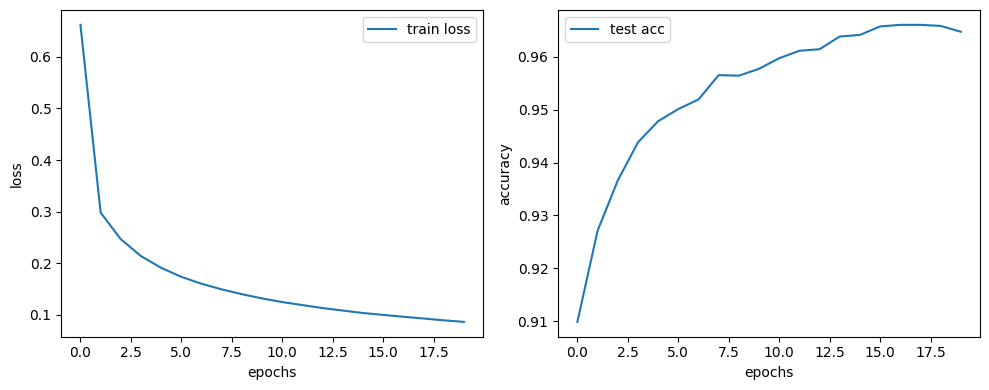

100%|██████████| 20/20 [04:36<00:00, 13.82s/it]

Training Done!


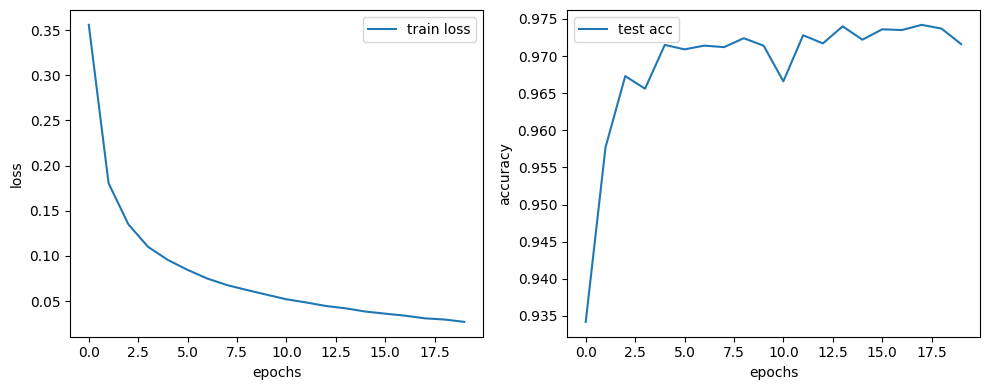

In [19]:
training(model1, 20, optimizer1)
training(model2, 20, optimizer2)

In [ ]:
# validation + early stopping


In [20]:
torch.save(model1.state_dict(), "modelSigmoid.pth")
print("Saved PyTorch Model State to modelSigmoid.pth")

torch.save(model2.state_dict(), "modelReLU.pth")
print("Saved PyTorch Model State to modelReLU.pth")

Saved PyTorch Model State to modelSigmoid.pth
Saved PyTorch Model State to modelReLU.pth


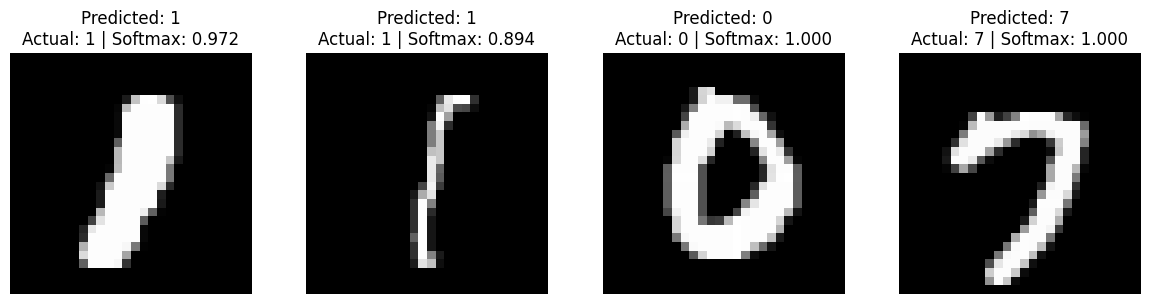

In [22]:
import random
import torch
import matplotlib.pyplot as plt

# MNIST classes (0-9)
classes = [str(i) for i in range(10)]

model2.eval()

fig, axes = plt.subplots(1, 4, figsize=(12, 3))

with torch.no_grad():
    for ax in axes:
        # Pick a random test sample
        idx = random.randint(0, len(test_data) - 1)
        x, y = test_data[idx]  # x: [1, 28, 28], y: int

        # Add batch dimension and move to device
        logits = model2(x.unsqueeze(0).to(device))      # [1, 10]
        probs = torch.softmax(logits, dim=1).squeeze() # [10]

        pred_idx = probs.argmax().item()
        conf = probs[pred_idx].item()

        # Plot image
        ax.imshow(x.squeeze(), cmap="gray")
        ax.set_title(
            f"Predicted: {classes[pred_idx]}\n"
            f"Actual: {classes[y]} | Softmax: {conf:.3f}"
        )
        ax.axis("off")

plt.tight_layout()
plt.show()